In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.3 MB/s eta 0:00:00


In [3]:
%cd '/content/drive/MyDrive/인지프'
%pwd

/content/drive/MyDrive/인지프


'/content/drive/MyDrive/인지프'

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
import tqdm
from tqdm.notebook import tqdm as notebooktqdm
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
import timm
from timm.layers import BatchNormAct2d
import os


In [5]:
# work place
work_dir = './'
os.chdir(work_dir)

In [6]:
class YoutubeDataset(Dataset):
    def __init__(self, data, doc2vec):
        self.ids = list(data['video_id'])
        self.titles = doc2vec # pretrained doc2vec features
        self.data = data # video_id, metadata, views(y) from csv file
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.image_encoder = timm.create_model('efficientnet_b1_pruned', features_only =True, pretrained=True)
        model = timm.create_model('efficientnet_b1_pruned', pretrained=True)
        data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
        self.transform = timm.data.create_transform(**data_cfg)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # index order of video_id, meta, y are same
        video_id = self.ids[idx]
        
        image = Image.open( work_dir+'medium_15287/{}.jpg'.format(video_id))
        image = self.transform(image)
        # image = torch.FloatTensor(np.array(image)).permute(2, 0, 1).unsqueeze(dim=0)
        self.image_encoder.eval()
        feature_map = self.image_encoder(torch.unsqueeze(image,0))[-1].squeeze() # (320,6,10)
        
        title = self.titles[video_id] # get video title
        title = torch.FloatTensor(np.array(title, dtype=np.float16))
        
        meta = torch.FloatTensor(self.data[['period_day', 'subscriber_count']].to_numpy()[idx]) # get metadata
        
        y = np.log10(self.data['views'].to_numpy() + 1) # add 1 for zero views
        y = np.expand_dims(y, axis=1) # add batch dimension
        y = torch.FloatTensor(y[idx]) # get log10(views+1) by idx value
        
        return video_id, feature_map, title, meta, y

In [7]:
# add nomarlizing
data = pd.read_csv('./train.csv')
mean_period = data['period_day'].mean()
std_period = data['period_day'].std()
mean_sub = data['subscriber_count'].mean()
std_sub = data['subscriber_count'].std()
print(mean_period, std_period, mean_sub, std_sub)

data['period_day'] = (data['period_day'] - mean_period)/std_period
data['subscriber_count'] = (data['subscriber_count']-mean_sub)/std_sub

train_data, valid_data = train_test_split(data, test_size = 0.1, random_state = 55)
test_data = pd.read_csv('./test.csv')
# train_data = train_data[:1000]
# valid_data = valid_data[:100]
# test_data = test_data[:100]
print('Train Dataset Size : ',len(train_data))
print('Validation Dataset Size : ',len(valid_data))
print('Test Dataset Size : ',len(test_data))

# data.head()

335.8148713475796 497.7613157973895 1784323.5617822357 3833786.6144638904
Train Dataset Size :  12382
Validation Dataset Size :  1376
Test Dataset Size :  1529


In [8]:
# open doc2vec data and conver to dict
with open('./title_doc2vec_10', 'rb') as f:
    doc2vec = pickle.load(f)

data_dict=dict()
for row in doc2vec:
    vid=row[0]
    vec=row[1:]
    data_dict[vid]=vec

doc2vec = data_dict
print(len(doc2vec))

15287


In [9]:
#setting hyper parameters
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
train_dataset = YoutubeDataset(train_data, doc2vec)
valid_dataset = YoutubeDataset(valid_data, doc2vec)
test_dataset = YoutubeDataset(test_data, doc2vec)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 1)
test_loader = DataLoader(test_dataset, batch_size = 1)

In [11]:
# !unzip -o ./medium_15287.zip -d ./medium_15287

data_list = os.listdir('./medium_15287')
print(len(data_list))

15287


In [12]:
class EcodingModel(nn.Module):
    def __init__(self):
        super(EcodingModel, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.feature_map_channel = 320
        self.feature_map_h = 6
        self.feature_map_w = 10

        self.efficient_net_channel1 = 1280
        self.efficient_net_channel2 = 1000

        # image squeezing
        self.img_squeeze_channel1 = self.efficient_net_channel2
        self.img_squeeze_channel2 = 2000
        self.img_squeeze_channel3 = 1000
        self.img_squeeze_channel4 = 500
        self.img_squeeze_channel_out = 100

        # title squeezing
        self.title_feature_channel = 10
        self.title_squeeze_channel1 = 200
        self.title_squeeze_channel2 = 100
        self.title_squeeze_channel3 = 50
        self.title_squeeze_channel_out = 10
        
        # efficient net
        self.effi1 = nn.Conv2d(self.feature_map_channel, self.efficient_net_channel1, kernel_size=(1,1), stride=(1,1), bias=False)
        self.effi2 = nn.BatchNorm2d(self.efficient_net_channel1, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        self.effi3 = nn.SiLU(inplace=True)
        self.effi4 = nn.AdaptiveAvgPool2d((1,1))
        self.effi5 = nn.Linear(self.efficient_net_channel1, self.efficient_net_channel2)
        
        # sqeeze img features
        self.img_squeeze_fc1 = nn.Linear(self.img_squeeze_channel1, self.img_squeeze_channel2)
        self.img_squeeze_fc2 = nn.Linear(self.img_squeeze_channel2, self.img_squeeze_channel3)
        self.img_squeeze_fc3 = nn.Linear(self.img_squeeze_channel3, self.img_squeeze_channel4)
        self.img_squeeze_fc_out = nn.Linear(self.img_squeeze_channel4, self.img_squeeze_channel_out)
 
        # sqeeze img and title features
        self.title_squeeze_fc1 = nn.Linear(self.img_squeeze_channel_out+self.title_feature_channel, self.title_squeeze_channel1)
        self.title_squeeze_fc2 = nn.Linear(self.title_squeeze_channel1, self.title_squeeze_channel2)
        self.title_squeeze_fc3 = nn.Linear(self.title_squeeze_channel2, self.title_squeeze_channel3)
        self.title_squeeze_fc_out = nn.Linear(self.title_squeeze_channel3, self.title_squeeze_channel_out)
 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.to(self.device)
    
    def forward(self, feature_map, title, meta):
        feature_map = feature_map.to(self.device)
        title = title.to(self.device)
        meta = meta.to(self.device)

        x = self.effi1(feature_map)
        x = self.effi2(x)
        x = self.effi3(x)
        x = torch.squeeze(self.effi4(x), dim=(2,3))
        x = self.effi5(x)

        x = self.img_squeeze_fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.img_squeeze_fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.img_squeeze_fc3(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.img_squeeze_fc_out(x)  # output size: 100
        x = self.dropout(x)
        x = self.relu(x) 

        img_title_feature = torch.cat([x, title], dim=1)
        img_title_feature = self.title_squeeze_fc1(img_title_feature)
        img_title_feature = self.dropout(img_title_feature)
        img_title_feature = self.relu(img_title_feature)
        img_title_feature = self.title_squeeze_fc2(img_title_feature)
        img_title_feature = self.dropout(img_title_feature)
        img_title_feature = self.relu(img_title_feature)
        img_title_feature = self.title_squeeze_fc3(img_title_feature)
        img_title_feature = self.dropout(img_title_feature)
        img_title_feature = self.relu(img_title_feature)
        img_title_feature = self.title_squeeze_fc_out(img_title_feature)  # output size: 10
        img_title_feature = self.dropout(img_title_feature)
        x = self.relu(img_title_feature)

        return x


    def encode(self, dataloader):
        device = self.device

        self.to(device)
        with torch.no_grad():
            self.eval()

            img_title_features = []
            titles = []
            metas = []
            targets = []

            for _, batch_image, batch_title, batch_meta, batch_target in dataloader:
                batch_image = batch_image.to(device)
                batch_title = batch_title.to(device)
                batch_meta = batch_meta.to(device)

                img_title_feature = self.forward(batch_image, batch_title, batch_meta)

                img_title_features.append(img_title_feature)
                titles.append(batch_title)
                metas.append(batch_meta)
                targets.append(batch_target)

            img_title_features = torch.cat(img_title_features, dim=0).cpu().numpy()
            titles = torch.cat(titles, dim=0).cpu().numpy()
            metas = torch.cat(metas, dim=0).cpu().numpy()
            targets = torch.cat(targets, dim=0).cpu().numpy()

        return img_title_features, metas, targets


In [13]:
encoder = EcodingModel()
encoder.to(encoder.device)
train_img_title, train_meta, train_target = encoder.encode(train_loader)

In [14]:
print(train_img_title.shape)

data = np.concatenate((train_img_title, train_meta), axis=1)
train_df = pd.DataFrame(data, columns=['img_title_{}'.format(i) for i in range(10)] + ['period_day', 'subscriber_count'])

train_df.head()
print(train_df.shape)

(12382, 10)
(12382, 12)


In [15]:
from xgboost import XGBClassifier
from xgboost import plot_importance

xgbc = XGBClassifier(random_state=111)
xgbc.fit(train_df, np.array(train_target, dtype='int'))



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

1.0


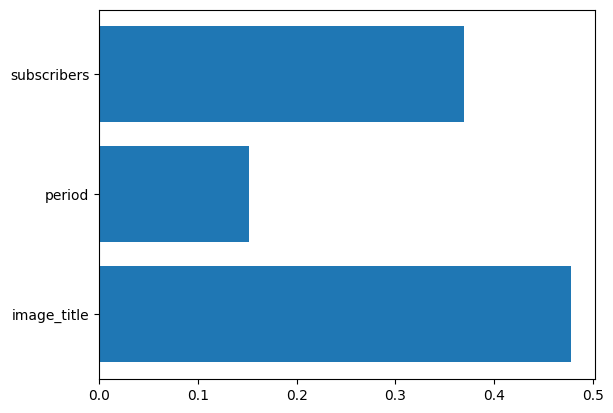

In [21]:
feature_impt = xgbc.feature_importances_

img_title_impt = np.sum(feature_impt[:10])
period_impt = feature_impt[-2]
subscriber_impt = feature_impt[-1]

print(img_title_impt + period_impt + subscriber_impt)

# plot_importance(xgbc, max_num_features=22)

plt.barh(['image_title', 'period', 'subscribers'], [img_title_impt, period_impt, subscriber_impt])
plt.show()